In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import stumpy
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf

import matplotlib.dates as dates
from matplotlib.patches import Rectangle, FancyArrowPatch
import datetime as dt

In [372]:
# Load your dataset
tf = 3600
df = np.load('trading_data/ohlcv.npy', allow_pickle= True).item()[tf]
df = pd.DataFrame(df, columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['dateTime'] = pd.to_datetime(df['Time'], unit= 's')
# df = df[:10000]
# # Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['High']])

# # Convert to PyTorch tensors
tensor_data = torch.Tensor(scaled_data)

# # Create a dataset and data loader
dataset = TensorDataset(tensor_data)

data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [380]:
ohlcv = dict(np.load('trading_data/ohlcv.npy', allow_pickle=True).item().items())
ohlcv = ohlcv.get(3600)
advantage = dict(np.load('trading_data/advantage.npy', allow_pickle=True).item().items())
advantage = advantage.get(3600)
df['advantage'] = advantage[:,1]

In [381]:
def look_forward_period(df, period):
    df["returns"] = df["Close"].pct_change(period).shift(-period) * 100
    df["max_return"] = df["returns"].rolling(period).max().shift(-period)
    
look_forward_period(df, 12)
df[:30]

,Time,Open,High,Low,Close,Volume,dateTime,returns,max_return,advantage
0,1.294006e+09,1.33436,1.33615,1.33395,1.33432,874.0,2011-01-02 22:00:00,-0.171623,0.680303,-0.037569
1,1.294009e+09,1.33430,1.33606,1.33339,1.33557,1093.0,2011-01-02 23:00:00,-0.319714,0.680303,-0.052108
2,1.294013e+09,1.33560,1.33587,1.33166,1.33211,2148.0,2011-01-03 00:00:00,0.201935,0.680303,-0.019854
3,1.294016e+09,1.33212,1.33234,1.32758,1.32814,2412.0,2011-01-03 01:00:00,0.492418,0.680303,0.019302
4,1.294020e+09,1.32815,1.32987,1.32765,1.32818,1472.0,2011-01-03 02:00:00,0.225873,0.680303,0.024035
5,1.294024e+09,1.32821,1.32935,1.32821,1.32902,1002.0,2011-01-03 03:00:00,0.538743,0.680303,0.021211
6,1.294027e+09,1.32897,1.32964,1.32868,1.32949,766.0,2011-01-03 04:00:00,0.563374,0.680303,0.021854
7,1.294031e+09,1.32949,1.33019,1.32919,1.32968,1028.0,2011-01-03 05:00:00,0.586607,0.680303,0.025082
8,1.294034e+09,1.32972,1.33091,1.32835,1.33089,1134.0,2011-01-03 06:00:00,0.483887,0.680303,0.017443
9,1.294038e+09,1.33089,1.33150,1.32500,1.32735,3413.0,2011-01-03 07:00:00,0.680303,0.559256,0.056734


In [382]:
df_train = df.iloc[:int(len(df)*0.8)]
df_test = df.iloc[int(len(df)*0.8):]

In [383]:
# def preprocess_data(df,k):
#     sequences = []
#     values = df.values.flatten()  # Extract values from the dataframe

#     for i in range(len(values) - k + 1):
#         sequence = list(range(i, i + k))
#         sequences.append([values[idx] for idx in sequence])
#     data = np.array(sequences)
#     distance_matrix = np.zeros((len(data), len(data)))
#     for i in range(len(data)):
#         Q_df = df[i:i+k]
#         T_df = df[:]
#         distance_matrix[i] = stumpy.mass(Q_df, T_df)
#     return data, distance_matrix

def preprocess_data(df,k):
    sequences = []
    values = df.values.flatten()  # Extract values from the dataframe

    for i in range(len(values) - k + 1):
        sequence = list(range(i, i + k))
        sequences.append([values[idx] for idx in sequence])
    data = np.array(sequences)
    distance_matrix = np.zeros((len(data), len(data)))
    stumpy.core.mass_distance_matrix(df, df, k, distance_matrix)
    return data, distance_matrix


# period = 12
# data_close, distance_matrix_close = preprocess_data(df["Close"], period)
# data_open, distance_matrix_open = preprocess_data(df["Open"], period)
# data_high, distance_matrix_high = preprocess_data(df["High"], period)
# data_low, distance_matrix_low = preprocess_data(df["Low"], period)

In [384]:
# data_close_train, distance_matrix_close_train = preprocess_data(df_train["Close"], period)
# print("data_close_train.shape: ", data_close_train.shape)

data_close_train.shape:  (62698, 12)


In [6]:
# mp = stumpy.stump(np.array(df_train["Close"]), 120)
# mp

array([[2.4478802889894413, 45471, -1, 45471],
       [2.534728607214215, 45471, -1, 45471],
       [2.4759319419919494, 38867, -1, 38867],
       ...,
       [3.594467669045627, 1574, 1574, -1],
       [3.5647004496585035, 1575, 1575, -1],
       [3.5475324964260864, 8850, 8850, -1]], dtype=object)

4.556311958925131

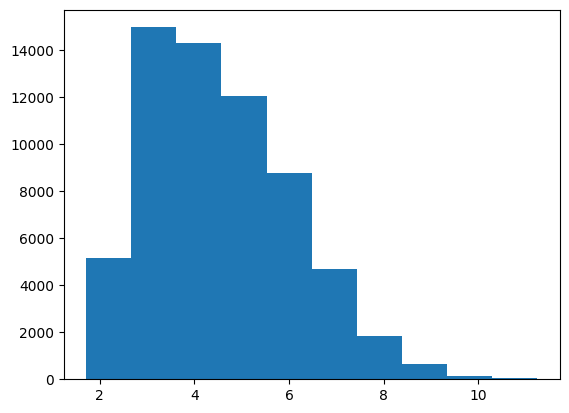

In [7]:
# plt.hist(mp[:, 0])
# # describe the distribution
# mp[:, 0].mean()

(array([6.2698000e+04, 0.0000000e+00, 6.0000000e+00, 6.6000000e+01,
        3.4800000e+02, 1.6940000e+03, 6.2180000e+03, 1.7540000e+04,
        4.0132000e+04, 8.3702000e+04, 1.5736400e+05, 2.7312800e+05,
        4.4579800e+05, 6.8607200e+05, 1.0056660e+06, 1.4133480e+06,
        1.9239020e+06, 2.5383120e+06, 3.2583860e+06, 4.0848620e+06,
        5.0178920e+06, 6.0545840e+06, 7.1876820e+06, 8.4025280e+06,
        9.7117600e+06, 1.1083548e+07, 1.2522110e+07, 1.4005344e+07,
        1.5539652e+07, 1.7116306e+07, 1.8715098e+07, 2.0314536e+07,
        2.1916914e+07, 2.3510920e+07, 2.5124956e+07, 2.6696608e+07,
        2.8279186e+07, 2.9811132e+07, 3.1331838e+07, 3.2824452e+07,
        3.4266028e+07, 3.5695322e+07, 3.7109622e+07, 3.8474944e+07,
        3.9784074e+07, 4.1066650e+07, 4.2332078e+07, 4.3568708e+07,
        4.4758450e+07, 4.5913542e+07, 4.7051628e+07, 4.8128846e+07,
        4.9210730e+07, 5.0281624e+07, 5.1298466e+07, 5.2332590e+07,
        5.3297748e+07, 5.4285876e+07, 5.5262582e

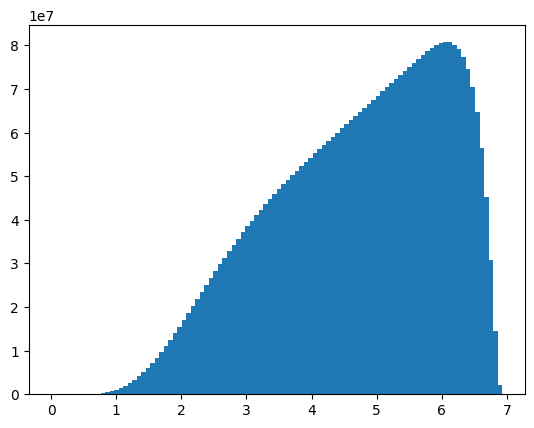

In [8]:
# x = distance_matrix_close_train.flatten()
# plt.hist(x, bins=100)

In [24]:
# import numpy as np

# def dbscan_with_distance_matrix(dist_matrix, eps, min_samples):
#     n_samples = dist_matrix.shape[0]
#     visited = np.zeros(n_samples, dtype=bool)
#     clusters = []
#     cluster_index = 0

#     def discount_eps_neighbors(degree_neighbor, eps, discount_factor = 0.7, speedup_factor = 1):
#         return eps * discount_factor**(degree_neighbor * speedup_factor)

#     def expand_cluster(cluster, point_index, neighbors, eps, min_samples):
#         cluster.append(point_index)
#         l_neighbor = 0
#         d_neighbor = 0
#         while d_neighbor < len(neighbors):
#             while l_neighbor < len(neighbors[d_neighbor]):
#                 # print(neighbors[l_neighbor], neighbors)
#                 neighbor = neighbors[d_neighbor][l_neighbor]
#                 if not visited[neighbor]:
#                     visited[neighbor] = True
#                     eps_neighbor = discount_eps_neighbors(d_neighbor, eps)
#                     new_neighbors = [j for j in range(point_index, n_samples) if dist_matrix[neighbor, j] <= eps_neighbor]
#                     if len(new_neighbors) >= min_samples:
#                         neighbors[d_neighbor + 1] = new_neighbors
#                         # print(neighbor, neighbors)
#                 if neighbor not in cluster:
#                     cluster.append(neighbor)
#                 l_neighbor += 1
#             d_neighbor += 1

#     for i in range(n_samples):
#         if not visited[i]:
#             visited[i] = True
#             neighbors = {0: [j for j in range(n_samples) if dist_matrix[i, j] <= eps]}
#             if len(neighbors[0]) < min_samples:
#                 continue

#             cluster = []
#             expand_cluster(cluster, i, neighbors, eps, min_samples)

#             clusters.append(cluster)

#             # print(f"Point {i} has neighbors {neighbors}")
#     return clusters

# # Example usage:
# # if __name__ == "__main__":
#     # Create a sample distance matrix (replace with your own)

# # Define DBSCAN parameters
# epsilon = 0.5
# min_samples = 15

# # Perform DBSCAN clustering with the distance matrix
# clusters = dbscan_with_distance_matrix(distance_matrix_close_train, epsilon, min_samples)



In [23]:
# from sklearn.metrics import silhouette_score
# np.fill_diagonal(distance_matrix_close_train, 0)
# def silhouette_calculate(clusters,distance_matrix):
#     cluster_labels = -np.ones(len(distance_matrix))
#     for cl in clusters:
#         cluster_data = distance_matrix[np.ix_(cl, cl)]
#         avg_distances = np.mean(cluster_data, axis=1)
#         most_representative_index = cl[np.argmin(avg_distances)]
#         for i in cl:
#             cluster_labels[i] = most_representative_index

#     clustered_labels = cluster_labels[cluster_labels != -1]  # Filter out outlier labels
#     clustered_distance_matrix = distance_matrix[cluster_labels != -1, :][:, cluster_labels != -1]  # Filter out outlier distances
#     silhouette_avg = silhouette_score(clustered_distance_matrix, clustered_labels, metric='precomputed')
#     return silhouette_avg
# silhouette_result = silhouette_calculate(clusters, distance_matrix_close_train)
# print("silhouette_result: ", silhouette_result)

silhouette_result:  0.031949845197459525


In [83]:
# df_train = df_train[["Close", "High", "Low"]]
# df_test = df_test[["Close", "High", "Low"]]

In [158]:
# # df_train = df_train - df_train.shift(-1)
# df_train_r = (df_train - df_train.shift(1))
# df_test_r = (df_test - df_test.shift(1))
# df_train_r = df_train_r.dropna()
# df_test_r = df_test_r.dropna()

Mean: 3.9239406700002877
Standard Deviation: 0.43577369720367065
Minimum: 1.3589244029946177
Maximum: 4.869030287691126
25th Percentile (Q1): 3.7081978258882886
Median (Q2): 4.006359672635391
75th Percentile (Q3): 4.231644106500724


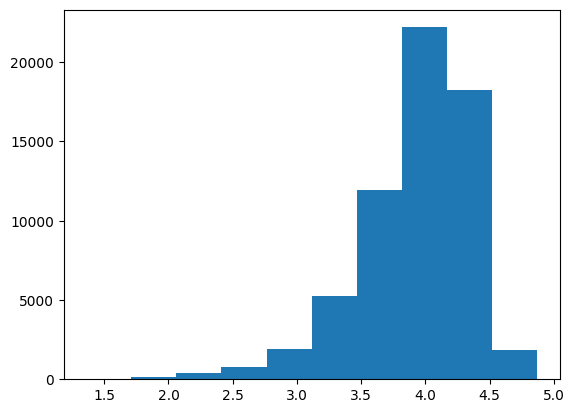

In [388]:
period = 30
mp_close = stumpy.stump(df_train_r["Close"], period, normalize=True)
plt.hist(mp_close[:,0])
mean_value = np.mean(mp_close[:,0])
std_deviation = np.std(mp_close[:,0])
min_value = np.min(mp_close[:,0])
max_value = np.max(mp_close[:,0])

# Calculate quartiles (25th, 50th, and 75th percentiles)
q1 = np.percentile(mp_close[:,0], 25)
median = np.percentile(mp_close[:,0], 50)
q3 = np.percentile(mp_close[:,0], 75)

# Print the results
print("Mean:", mean_value)
print("Standard Deviation:", std_deviation)
print("Minimum:", min_value)
print("Maximum:", max_value)
print("25th Percentile (Q1):", q1)
print("Median (Q2):", median)
print("75th Percentile (Q3):", q3)

In [389]:
motif_distance, motifs_idx = stumpy.motifs(df_train["Close"], mp_close[:,0], min_neighbors=2, max_distance=4.2, cutoff=4.2, max_matches=100000, max_motifs=270)
print(len(motifs_idx))
motifs_idx.shape

173


(173, 1247)

In [588]:
import numpy as np
from itertools import product

def generate_shapelets(length, max_value):
    # Generate all unique combinations of values
    unique_combinations = list(product(range(max_value + 1), repeat=length))

    # Convert combinations to arrays
    arrays = [np.array(combination) for combination in unique_combinations]

    # Normalize and remove duplicates
    unique_arrays = []
    seen_array = []
    for array in arrays:
        normalized_array = np.array((array - np.mean(array))/np.std(array))
        if not any(np.array_equal(normalized_array, arr) for arr in seen_array):
            seen_array.append(normalized_array)
            unique_arrays.append(array)
    return unique_arrays

# all_shapelets = np.array(generate_shapelets(length = 5, max_value = 3)).astype(np.float64)


In [589]:
length = 5
max_value = 5
all_shapelets = np.array(generate_shapelets(length = length, max_value = max_value)).astype(np.float64)
print("max_value: ", max_value, "all_shapelets.shape: ", all_shapelets.shape)



/tmp/ipykernel_770781/1344503561.py:15: RuntimeWarning: invalid value encountered in divide
  normalized_array = np.array((array - np.mean(array))/np.std(array))


max_value:  5 all_shapelets.shape:  (5030, 5)


In [435]:
one_hot_shapelets_train = np.zeros((len(all_shapelets), len(df_train["Close"])-length+1))
for i, shapelet in enumerate(all_shapelets):
    distance = stumpy.core.mass(shapelet, df_train["Close"], normalize=True)
    one_hot_shapelets_train[i, distance < 1/np.sqrt(length)] = 1

In [494]:
one_hot_shapelets_test = np.zeros((len(all_shapelets), len(df_test["Close"])-length+1))
for i, shapelet in enumerate(all_shapelets):
    distance = stumpy.core.mass(shapelet, df_test["Close"], normalize=True)
    one_hot_shapelets_test[i, distance < 1/np.sqrt(length)] = 1

(array([ 729., 1694.,  884.,  532.,  251.,  168.,  125.,   89.,   75.,
          55.,   53.,   44.,   42.,   41.,   28.,   27.,   22.,   21.,
          32.,   17.,   21.,   17.,    5.,   11.,   13.,   17.,    6.,
           6.,    2.,    3.]),
 array([  0.        ,  29.63333333,  59.26666667,  88.9       ,
        118.53333333, 148.16666667, 177.8       , 207.43333333,
        237.06666667, 266.7       , 296.33333333, 325.96666667,
        355.6       , 385.23333333, 414.86666667, 444.5       ,
        474.13333333, 503.76666667, 533.4       , 563.03333333,
        592.66666667, 622.3       , 651.93333333, 681.56666667,
        711.2       , 740.83333333, 770.46666667, 800.1       ,
        829.73333333, 859.36666667, 889.        ]),
 <BarContainer object of 30 artists>)

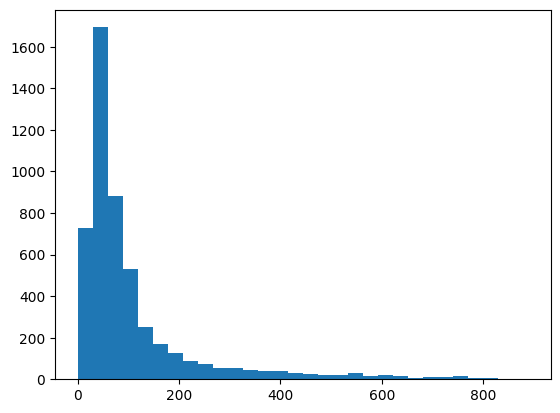

In [458]:
plt.hist(one_hot_shapelets_train.sum(axis=1), bins = 30)

/tmp/ipykernel_770781/3883495674.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax[i].plot(x[np.argmin(z):np.argmin(z)+len(y)])


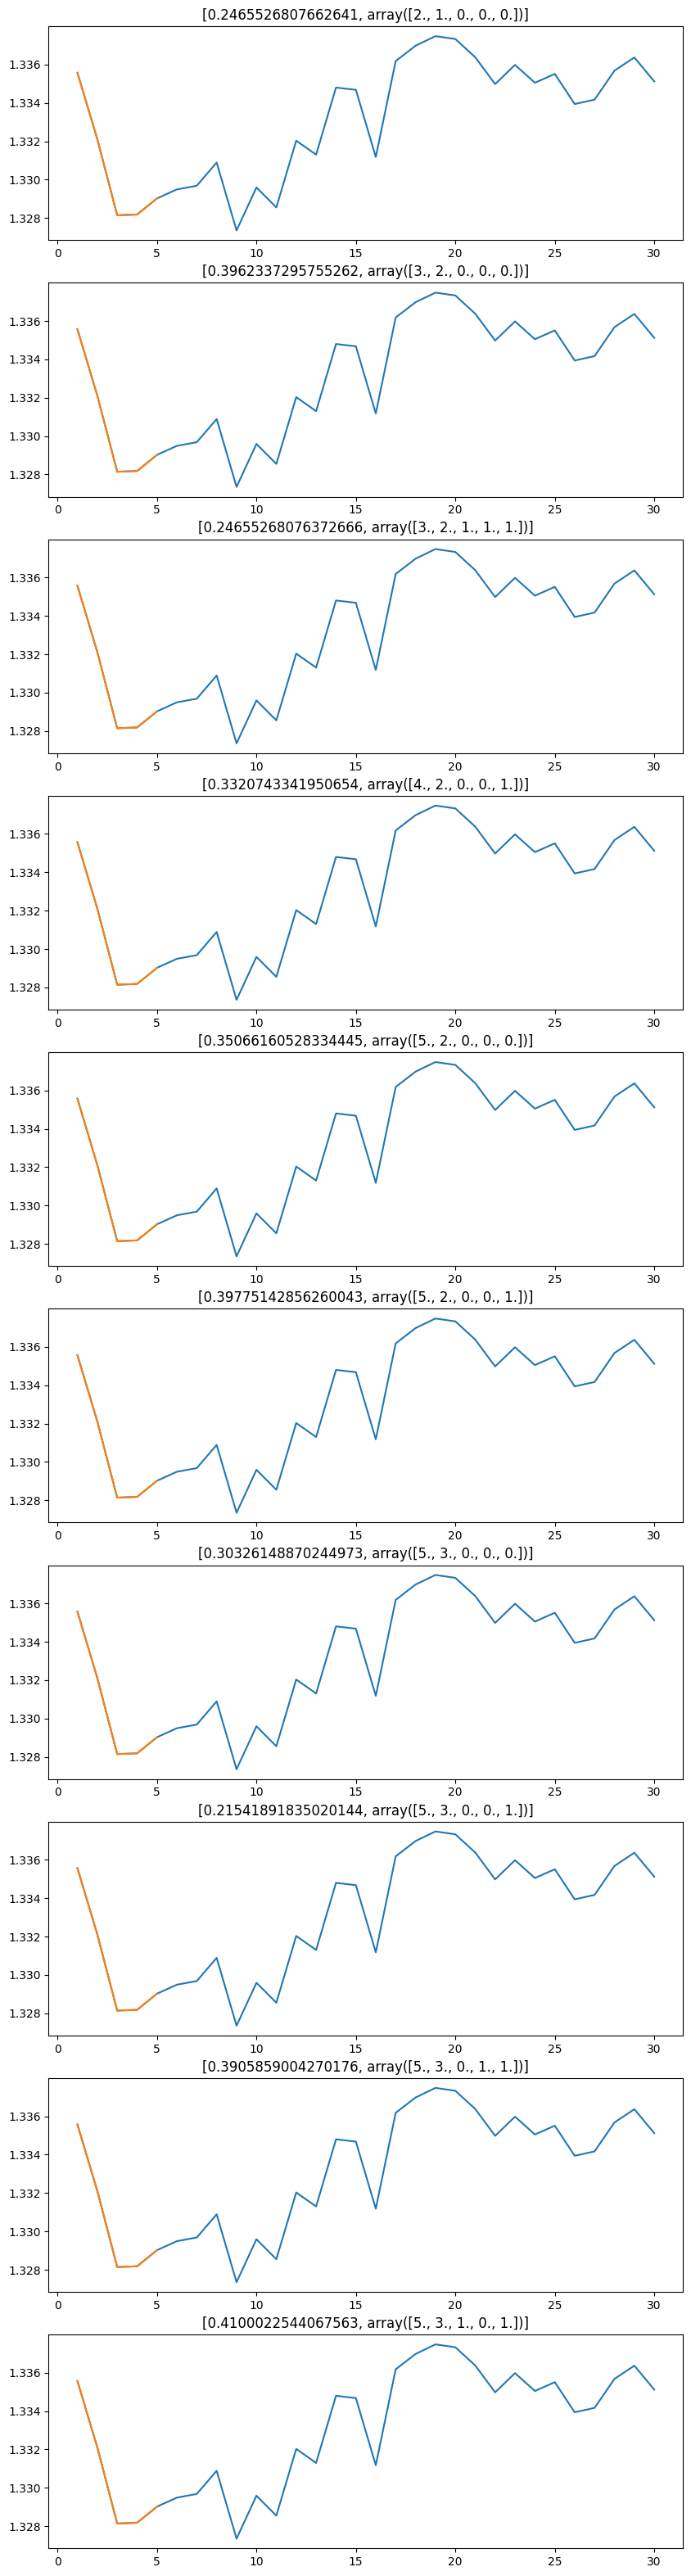

In [483]:
# plt.plot(df_train["Close"][motifs_idx[1][0]:motifs_idx[1][0]+period])
# plt.axis('off')
index = 1
x = df["Close"][index:index+period]
fig, ax = plt.subplots(len(all_shapelets[np.where(one_hot_shapelets[:,index] == 1)[0]]),1, figsize=(10,40))
for i, y in enumerate(all_shapelets[np.where(one_hot_shapelets[:,index] == 1)[0]]):
    # print(stumpy.core.mass(np.array([5,3,1,1,2]).astype(np.float64), x, normalize=True))
    z = stumpy.core.mass(y, x, normalize=True)
    # print(z)
    # print(np.min(z))
    ax[i].plot(x)
    ax[i].plot(x[np.argmin(z):np.argmin(z)+len(y)])
    ax[i].set_title([np.min(z), y])

In [498]:
X_train = one_hot_shapelets_train.T
X_test = one_hot_shapelets_test.T
# one_hot_shapelets.shape
y_train = np.array(df_train["advantage"][:-length+1])
y_test = np.array(df_test["advantage"][:-length+1])

/tmp/ipykernel_770781/4064445893.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_test = np.array(df_test["advantage"][:-length+1])


In [539]:
y_train_cat = y_train > 0
y_test_cat = y_test > 0

In [540]:
from tensorflow import keras
from tensorflow.keras import layers
n_features = X_train.shape[1]

# Create a feedforward neural network model
# model = keras.Sequential([
#     layers.Input(shape=(n_features,)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1)  # Output layer with 1 neuron for the continuous output
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_split=0.2)

model = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation for binary classification
])

# Compile the model with binary cross-entropy loss for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
1568/1568 [==============================] - 85s 54ms/step - loss: 0.4767 - accuracy: 0.7891 - val_loss: 0.4620 - val_accuracy: 0.7928
Epoch 2/50
1568/1568 [==============================] - 68s 43ms/step - loss: 0.4463 - accuracy: 0.8063 - val_loss: 0.4660 - val_accuracy: 0.7914
Epoch 3/50
1568/1568 [==============================] - 61s 39ms/step - loss: 0.4348 - accuracy: 0.8128 - val_loss: 0.4697 - val_accuracy: 0.7888
Epoch 4/50
1568/1568 [==============================] - 67s 43ms/step - loss: 0.4224 - accuracy: 0.8212 - val_loss: 0.4765 - val_accuracy: 0.7856
Epoch 5/50
1568/1568 [==============================] - 73s 47ms/step - loss: 0.4063 - accuracy: 0.8289 - val_loss: 0.4924 - val_accuracy: 0.7809
Epoch 6/50
1568/1568 [==============================] - 67s 43ms/step - loss: 0.3860 - accuracy: 0.8368 - val_loss: 0.5166 - val_accuracy: 0.7782
Epoch 7/50
1568/1568 [==============================] - 74s 47ms/step - loss: 0.3650 - accuracy: 0.8455 - val_loss: 0.5315 -

In [541]:
# Evaluate the model on the test set
y_pred_cat = model.predict(X_test)
loss = model.evaluate(X_test, y_test_cat)
print("Mean Squared Error on Test Set:", loss)

490/490 [==============================] - 17s 36ms/step - loss: 1.6789 - accuracy: 0.7301
Mean Squared Error on Test Set: [1.678913950920105, 0.7300625443458557]


In [551]:
y_pred_prob = model.predict(X_test)
y_pred_prob = y_pred_prob.flatten()
y_pred_cat = (y_pred_prob > 0.5).astype(int)
y_pred_cat

490/490 [==============================] - 20s 40ms/step


Accuracy: 0.7300625239249713
Precision: 0.7213443691998996
Recall: 0.7411416054632135
F1 Score: 0.7311089926914522
ROC AUC Score: 0.758228102408565
Confusion Matrix:
[[5691 2222]
 [2009 5752]]


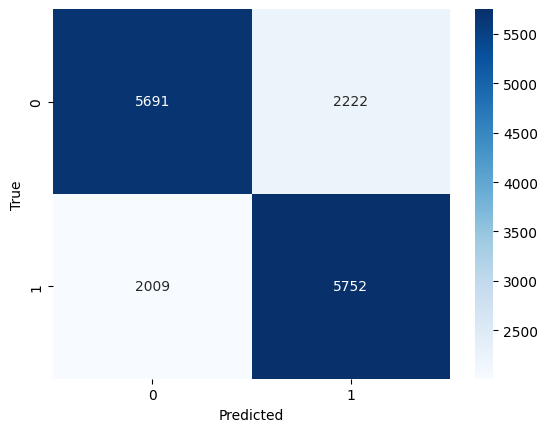

In [556]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
accuracy = accuracy_score(y_test_cat, y_pred_cat)
precision = precision_score(y_test_cat, y_pred_cat)
recall = recall_score(y_test_cat, y_pred_cat)
f1 = f1_score(y_test_cat, y_pred_cat)
roc_auc = roc_auc_score(y_test_cat, y_pred_prob)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_cat, y_pred_cat)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix as a Heatmap
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [563]:
one_hot_shapelets = np.zeros((len(all_shapelets), len(df["Close"])-length+1))
for i, shapelet in enumerate(all_shapelets):
    distance = stumpy.core.mass(shapelet, df["Close"], normalize=True)
    one_hot_shapelets[i, distance < 1/np.sqrt(length)] = 1

In [575]:
#Shuffle the data
num_samples = len(df["Close"])-length+1
shuffled_indices = np.random.permutation(num_samples)

test_size = 0.2
# Calculate the number of samples for the test set
num_test_samples = int(test_size * num_samples)

# Split the shuffled indices into training and test indices
train_indices = shuffled_indices[num_test_samples:]
test_indices = shuffled_indices[:num_test_samples]
X_train_new = one_hot_shapelets.T[train_indices]
X_test_new = one_hot_shapelets.T[test_indices]
y_train_cat_new = df["advantage"][:-length+1][train_indices] > 0
y_test_cat_new = df["advantage"][:-length+1][test_indices] > 0

In [582]:
from tensorflow import keras
from tensorflow.keras import layers
n_features = X_train_new.shape[1]

# Create a feedforward neural network model
# model = keras.Sequential([
#     layers.Input(shape=(n_features,)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(1)  # Output layer with 1 neuron for the continuous output
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Train the model
# history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_split=0.2)

model1 = keras.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation for binary classification
])

# Compile the model with binary cross-entropy loss for binary classification
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history1 = model1.fit(X_train_new, y_train_cat_new, epochs=30, batch_size=32, validation_split=0.2)


/home/cdl/anaconda3/envs/backtest/lib/python3.10/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/30
1568/1568 [==============================] - 88s 56ms/step - loss: 0.4738 - accuracy: 0.7895 - val_loss: 0.4681 - val_accuracy: 0.7943
Epoch 2/30
1568/1568 [==============================] - 95s 61ms/step - loss: 0.4438 - accuracy: 0.8077 - val_loss: 0.4730 - val_accuracy: 0.7900
Epoch 3/30
1568/1568 [==============================] - 86s 55ms/step - loss: 0.4326 - accuracy: 0.8149 - val_loss: 0.4778 - val_accuracy: 0.7870
Epoch 4/30
1568/1568 [==============================] - 94s 60ms/step - loss: 0.4198 - accuracy: 0.8225 - val_loss: 0.4822 - val_accuracy: 0.7848
Epoch 5/30
1568/1568 [==============================] - 90s 57ms/step - loss: 0.4028 - accuracy: 0.8301 - val_loss: 0.4936 - val_accuracy: 0.7846
Epoch 6/30
1568/1568 [==============================] - 90s 58ms/step - loss: 0.3809 - accuracy: 0.8397 - val_loss: 0.5146 - val_accuracy: 0.7764
Epoch 7/30
1568/1568 [==============================] - 92s 58ms/step - loss: 0.3599 - accuracy: 0.8487 - val_loss: 0.5427 -

In [583]:
y_pred_prob_new = model1.predict(X_test_new)
y_pred_prob_new = y_pred_prob_new.flatten()
y_pred_cat_new = (y_pred_prob_new > 0.5).astype(int)
y_pred_cat_new

490/490 [==============================] - 17s 34ms/step


array([1, 0, 1, ..., 1, 1, 0])

Accuracy: 0.7331589691247767
Precision: 0.7281203381402287
Recall: 0.7458296192537883
F1 Score: 0.7368685915581554
ROC AUC Score: 0.7331346741290035
Confusion Matrix:
[[5636 2187]
 [1996 5857]]


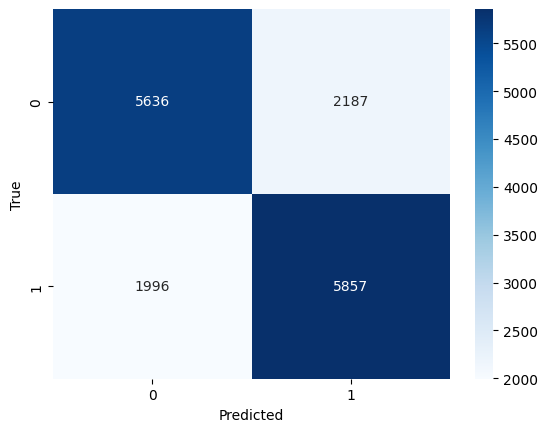

In [584]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
accuracy = accuracy_score(y_test_cat_new, y_pred_cat_new)
precision = precision_score(y_test_cat_new, y_pred_cat_new)
recall = recall_score(y_test_cat_new, y_pred_cat_new)
f1 = f1_score(y_test_cat_new, y_pred_cat_new)
roc_auc = roc_auc_score(y_test_cat_new, y_pred_cat_new)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_cat_new, y_pred_cat_new)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix as a Heatmap
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [533]:
# result = np.zeros(X_train.shape[1])
# for i in range(len(result)):
#     result[i] = (y_train[np.where(X_train[:,i] == 1)]>0).sum()/len(y_train[np.where(X_train[:,i] == 1)])

/tmp/ipykernel_770781/194174704.py:3: RuntimeWarning: invalid value encountered in scalar divide
  result[i] = (y_train[np.where(X_train[:,i] == 1)]>0).sum()/len(y_train[np.where(X_train[:,i] == 1)])


(array([ 52., 151., 171., 200., 231., 155., 174., 157., 175., 149., 184.,
        186., 210., 160., 124., 220., 168., 170., 151., 197., 174., 187.,
        133., 186., 184., 209., 198., 178., 136.,  54.]),
 array([0.03338898, 0.06449078, 0.09559258, 0.12669438, 0.15779618,
        0.18889798, 0.21999978, 0.25110157, 0.28220337, 0.31330517,
        0.34440697, 0.37550877, 0.40661057, 0.43771237, 0.46881417,
        0.49991597, 0.53101777, 0.56211957, 0.59322136, 0.62432316,
        0.65542496, 0.68652676, 0.71762856, 0.74873036, 0.77983216,
        0.81093396, 0.84203576, 0.87313756, 0.90423935, 0.93534115,
        0.96644295]),
 <BarContainer object of 30 artists>)

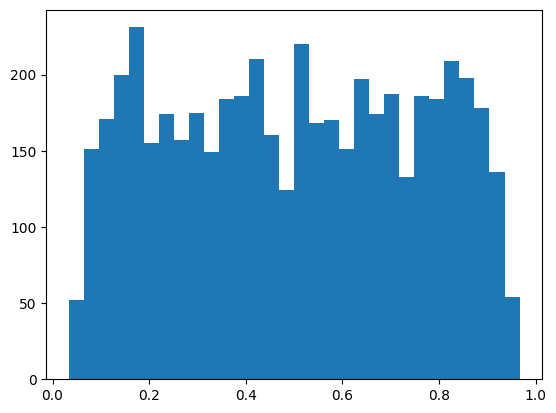

In [535]:
# plt.hist(result, bins = 30)

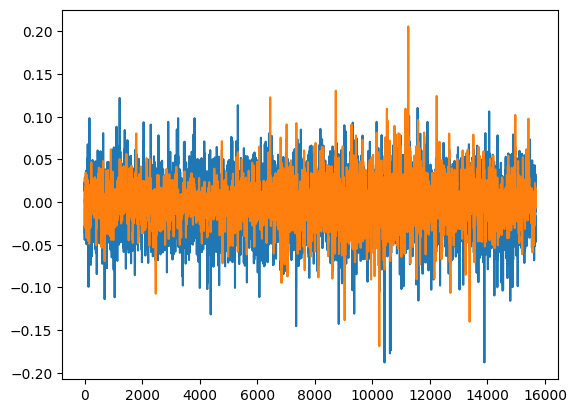

In [537]:
# plt.plot(y_pred)
# plt.plot(y_test)

In [392]:
# length = 5
# one_hot_shapelets = np.zeros((len(all_shapelets), len(df_train["Close"]) - length + 1))
# for i, shapelet in enumerate(all_shapelets):
#     distance = stumpy.core.mass(shapelet, df_train["Close"], normalize=True)
#     one_hot_shapelets[i, distance < 1/length] = 1


2387
3301
3416
4140
4226
4239
4240
4245
4246
4984
4985


IndexError: index 10 is out of bounds for axis 0 with size 10

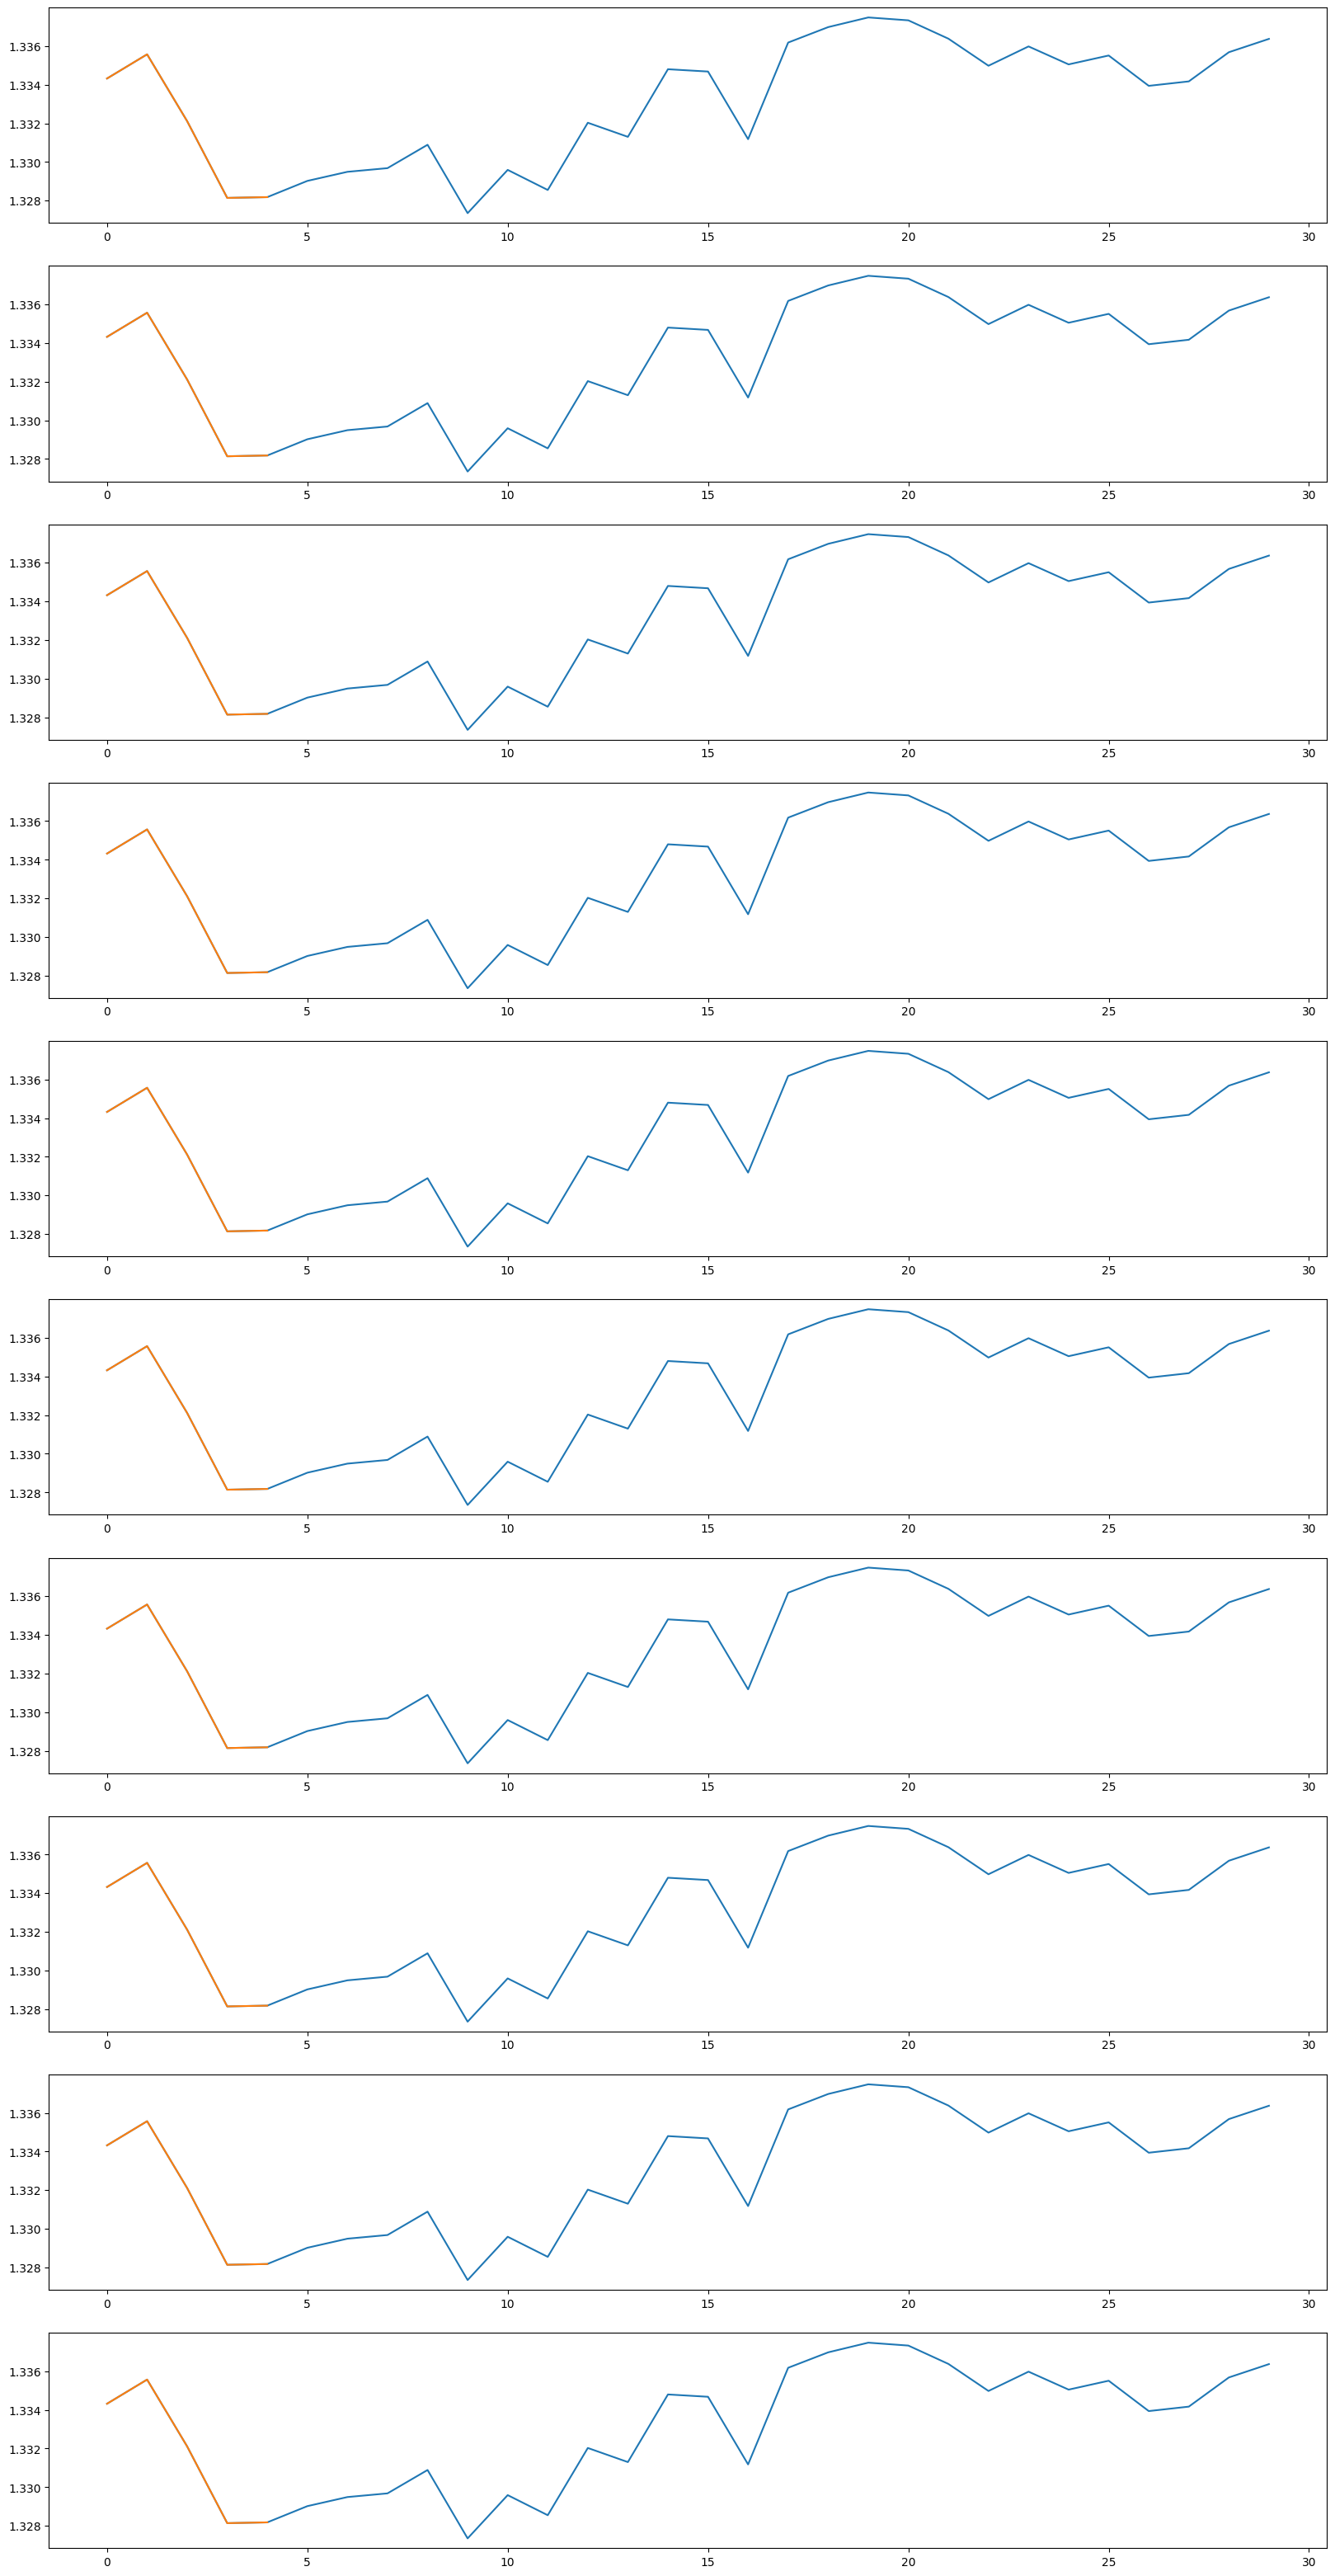

In [476]:
# fig, ax = plt.subplots(10,1, figsize=(20,40))
# for i, shapelet in enumerate(np.where(one_hot_shapelets[:,0] == 1)[0]):
#     print(shapelet)
#     ax[i].plot(df_train["Close"][0:0+period])
#     ax[i].plot(df_train["Close"][0:0+length])


In [191]:
# distance_cluster_matrix = np.zeros((len(motifs_idx), len(motifs_idx)))
# for i in range(len(motifs_idx)):
#     for j in range(len(motifs_idx)):
#         distance_cluster_matrix[i,j] = stumpy.mass(df_train["Close"][motifs_idx[i][0]:motifs_idx[i][0]+m], df_train["Close"][motifs_idx[j][0]:motifs_idx[j][0]+m])[0]

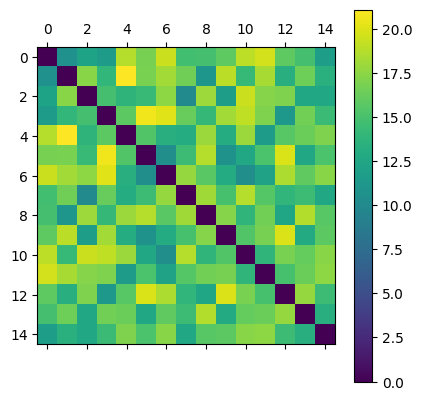

In [192]:
# plt.matshow(distance_cluster_matrix)
# plt.colorbar()

19.036067129813354

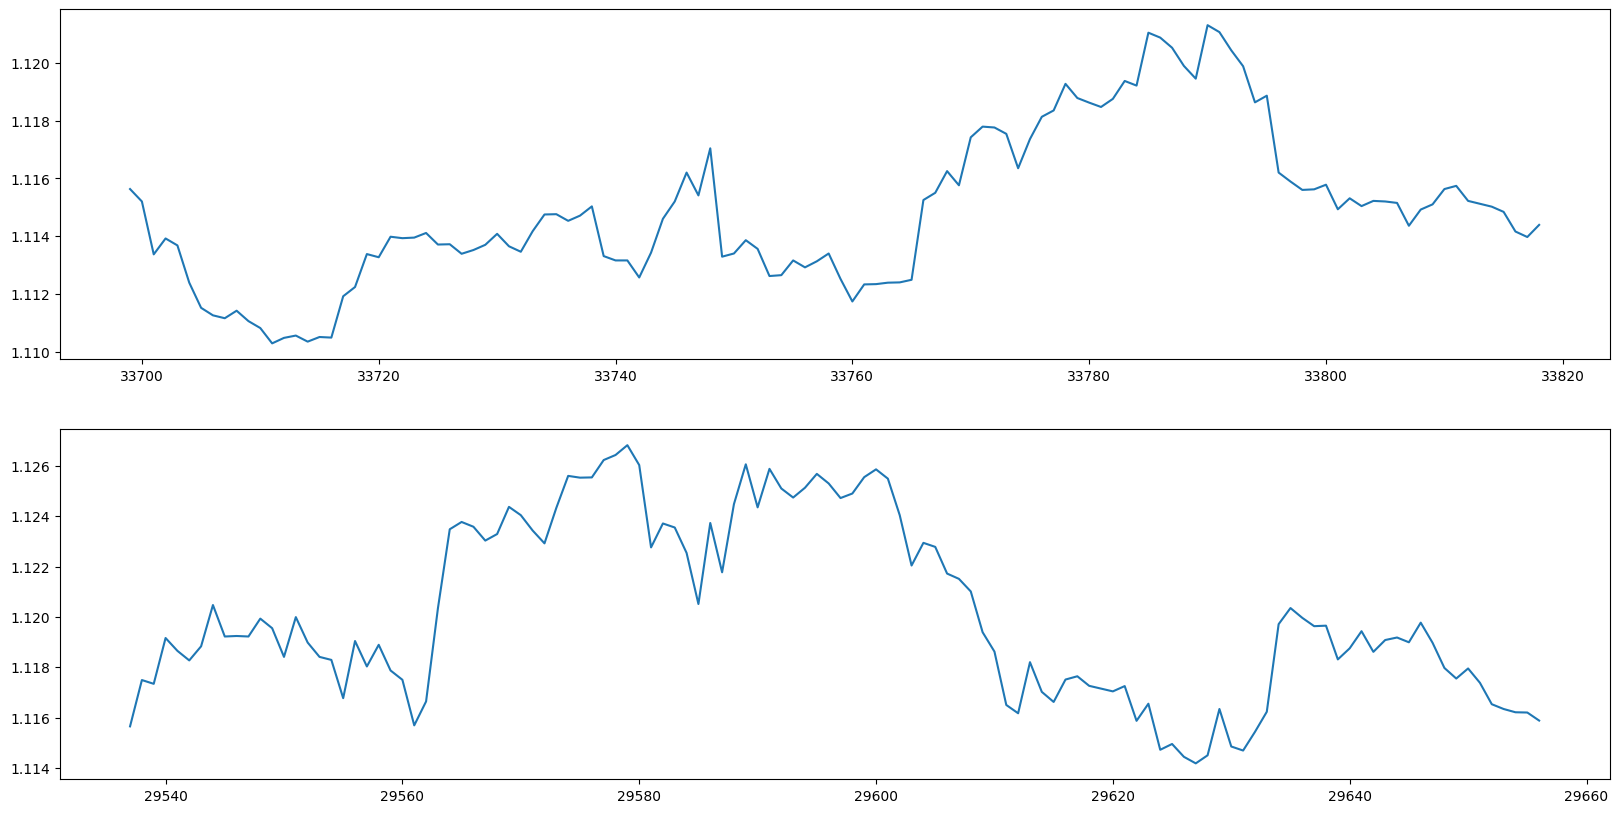

In [194]:
# fig, ax = plt.subplots(2, 1, sharex=False, figsize=(20, 10))
# i = 10
# ax[0].plot(df_train["Close"][motifs_idx[0][0]:motifs_idx[0][0]+m])
# ax[1].plot(df_train["Close"][motifs_idx[i][0]:motifs_idx[i][0]+m])

# stumpy.mass(df_train["Close"][motifs_idx[0][0]:motifs_idx[0][0]+m], df_train["Close"][motifs_idx[i][0]:motifs_idx[i][0]+m])[0]

In [195]:
# np.fill_diagonal(distance_cluster_matrix, np.inf)
# for i in range(len(distance_cluster_matrix)):
#     print(distance_cluster_matrix[i][np.argmin(distance_cluster_matrix, axis=1)[i]], np.argmin(distance_cluster_matrix, axis=1)[i])

10.65064705814074 1
10.65064705814074 0
10.131907285669797 7
11.27436961167692 12
11.567806514271846 11
10.40470115467367 6
10.40470115467367 5
10.131907285669797 2
11.075014599675205 1
10.722540453094052 5
10.415432601057422 6
11.567806514271846 4
11.27436961167692 3
12.646746828586574 5
11.801600675336521 0


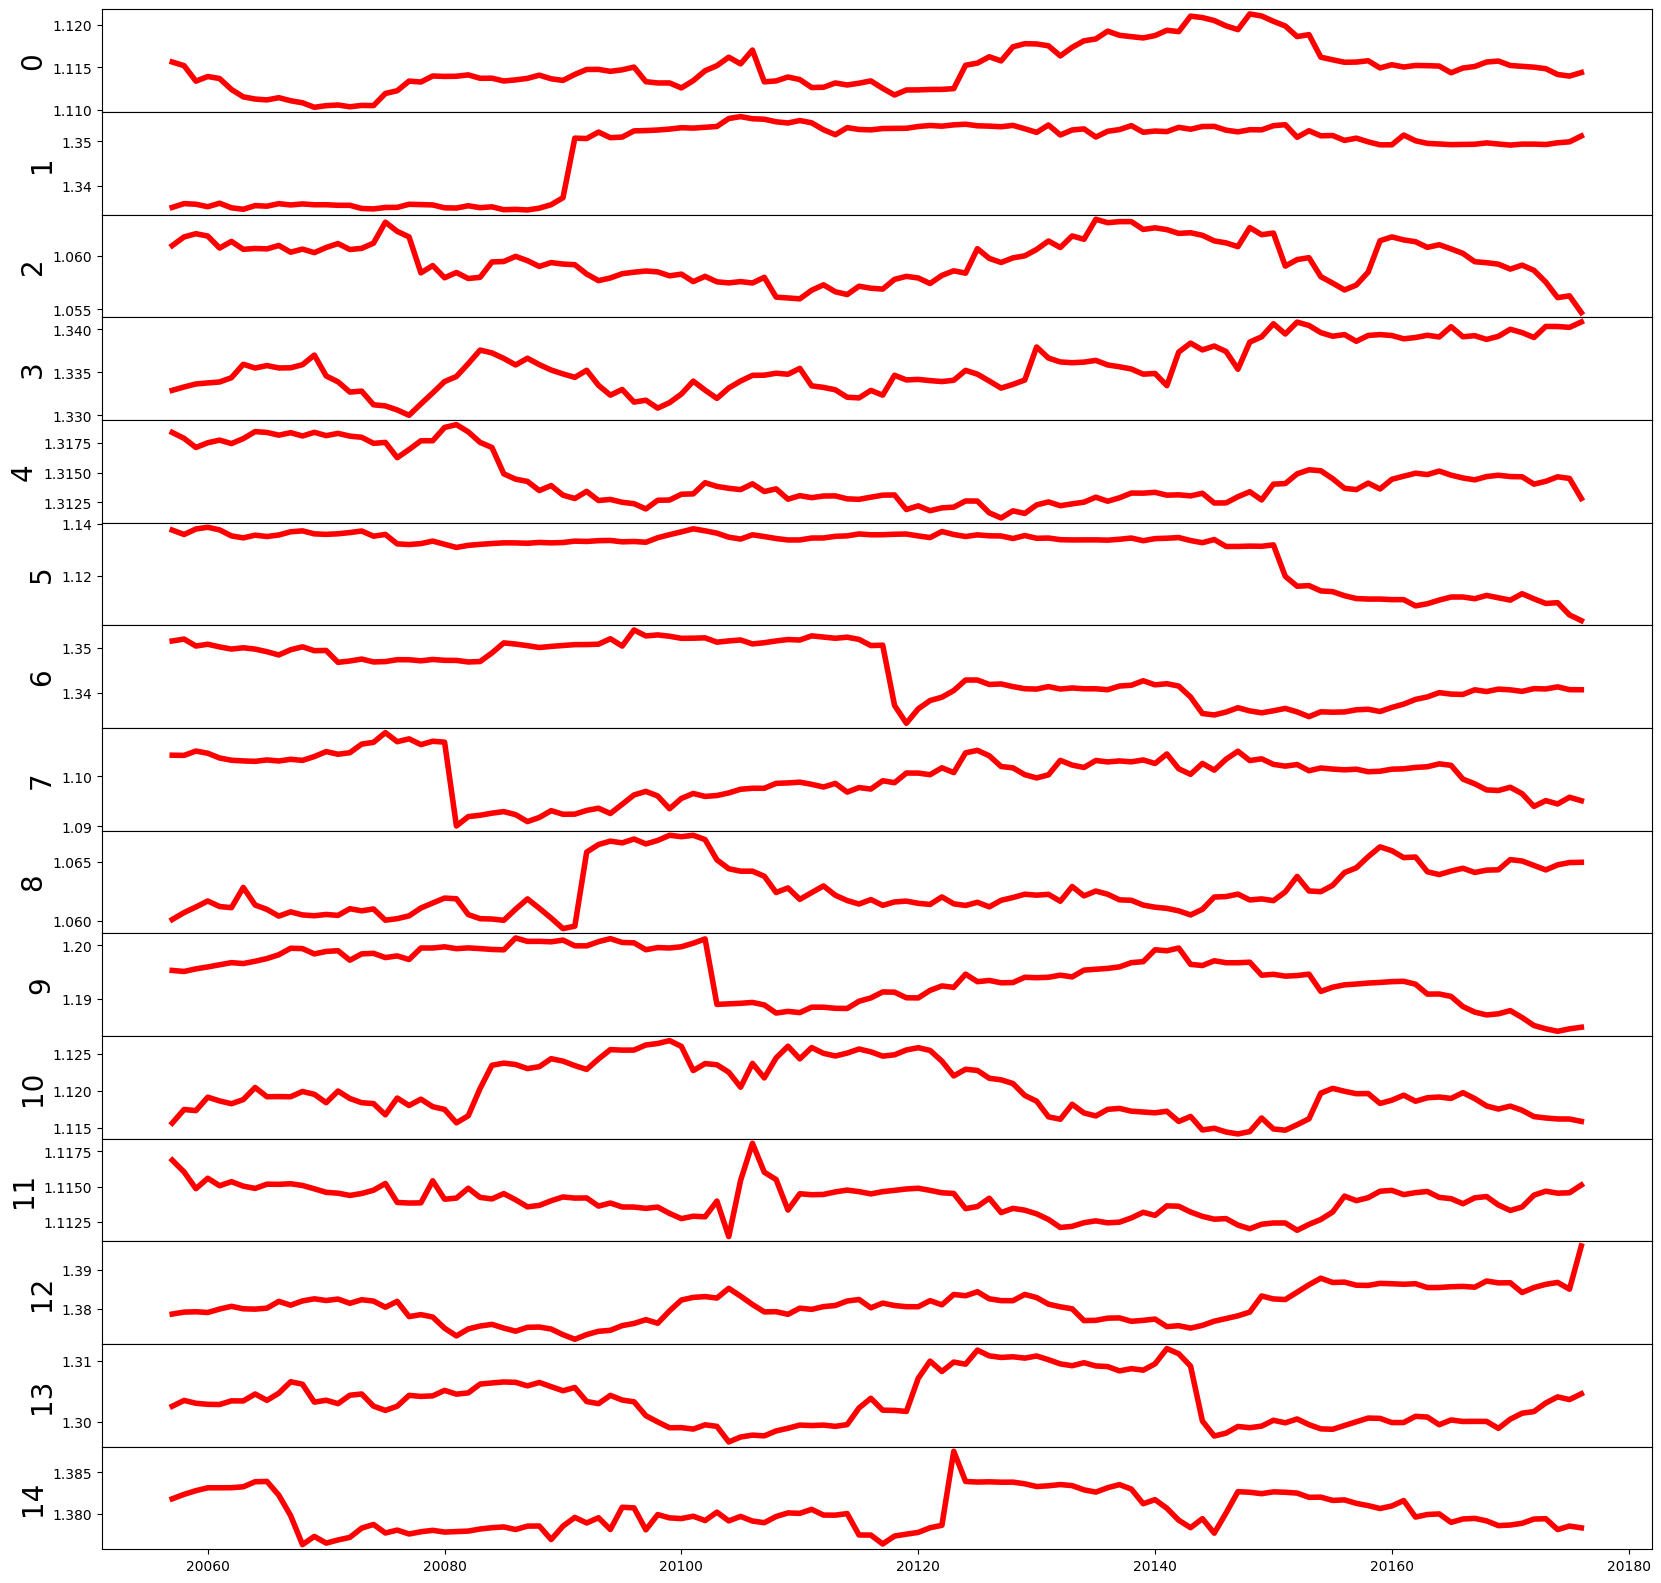

In [228]:

# fg, ax = plt.subplots(motifs_idx.shape[0], sharex=False, gridspec_kw={'hspace': 0}, figsize=(20, 20))
# for i in range(motifs_idx.shape[0]):
#     ax[i].plot(df_train["Close"][motifs_idx[i][0]:motifs_idx[i][0]+period], c='red', linewidth='4')
#     ax[i].set_ylabel(i, fontsize='20')

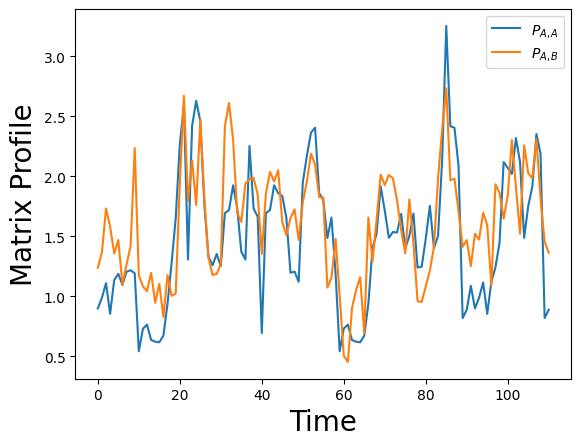

In [229]:
# m = 10
# p_a_a = stumpy.stump(
#         T_A = df_train["Close"][motifs_idx[0][0]:motifs_idx[0][0]+period], 
#         m = m, 
#         ignore_trivial=False)[:,0].astype(np.float64)
# p_a_b = stumpy.stump(
#         T_A = df_train["Close"][motifs_idx[0][0]:motifs_idx[0][0]+period], 
#         m = m, 
#         T_B=df_train["Close"][motifs_idx[1][0]:motifs_idx[1][0]+period], 
#         ignore_trivial=False)[:,0].astype(np.float64)
# plt.plot(p_a_a, label="$P_{A,A}$")
# plt.plot(p_a_b, color="C1", label="$P_{A,B}$")
# plt.xlabel("Time", fontsize="20")
# plt.ylabel("Matrix Profile", fontsize="20")
# plt.legend()
# plt.show()

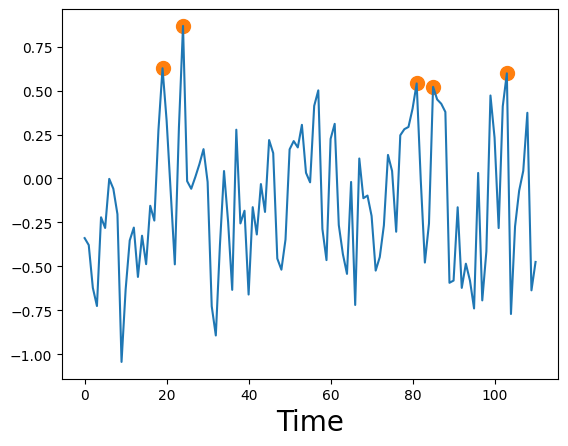

In [230]:
# P_diff = p_a_a - p_a_b
# k = 5
# idx = np.argpartition(np.nan_to_num(P_diff), -k)[-k:]  # get the top 10 peak locations in P_diff
# plt.suptitle("", fontsize="30")
# plt.xlabel("Time", fontsize="20")
# plt.plot(idx, P_diff[idx], color="C1", marker="o", linewidth=0, markersize=10)
# plt.plot(P_diff)
# plt.show()

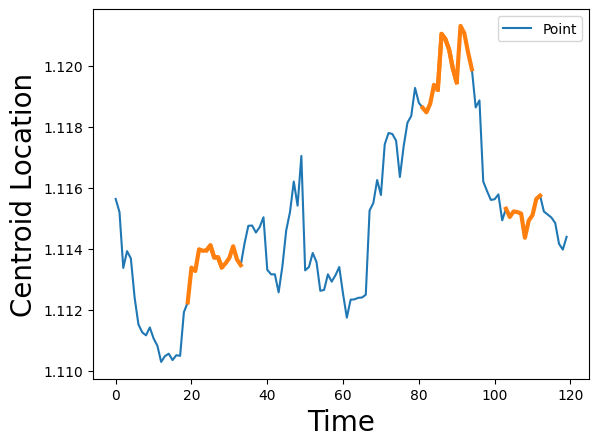

In [231]:
# # plt.axis('off')
# point_shapelets = []
# for i in idx:
#     shapelet = df_train["Close"][motifs_idx[0][0]: motifs_idx[0][0]+period].iloc[i : i + m]
#     point_shapelets.append(shapelet)

# plt.xlabel("Time", fontsize="20")
# plt.ylabel('Centroid Location', fontsize='20')
# plt.plot(df_train["Close"][motifs_idx[0][0]: motifs_idx[0][0]+period].reset_index(drop = True), label="Point")
# for i, shapelet in zip(idx, point_shapelets):
#     plt.plot(range(i, i + m), shapelet, color="C1", linewidth=3.0)
# plt.legend()
# plt.show()

In [ ]:
# list_clusters = []
# for eps in range(5, 20):
#     eps = eps/10
#     for min_samples in range(5, 15):
#         clusters = dbscan_with_distance_matrix(distance_matrix_close_train, eps, min_samples)
#         list_clusters.append(clusters)
#         silhouette_result = silhouette_calculate(clusters, distance_matrix_close_train)
#         print("eps: ", eps, " min_samples: ", min_samples, " silhouette_result: ", silhouette_result)

In [586]:
# import random

# class IndependentIncrementAgent:
#     def __init__(self, epsilon_step_size, min_samples_step_size, discount_factor_step_size, speed_up_factor_step_size):
#         self.epsilon = random.uniform(0, 1)
#         self.min_samples = random.randint(1, 100)
#         self.discount_factor = random.uniform(0, 1)
#         self.speed_up_factor = random.uniform(0, 1)
#         self.result = self.calculate_result()
#         self.epsilon_step_size, self.min_samples_step_size, self.discount_factor_step_size, self.speed_up_factor_step_size = epsilon_step_size, min_samples_step_size, discount_factor_step_size, speed_up_factor_step_size
    
#     def take_action(self, current_reward):
#         # Calculate the current result
#         current_result = current_reward

#         # Calculate the reward for each input based on the change in the result
#         reward = self.calculate_result(epsilon=self.epsilon + epsilon_step_size, min_samples=self.min_samples + min_samples_step_size, discount_factor=self.discount_factor + discount_factor_step_size, speed_up_factor=self.speed_up_factor + speed_up_factor_step_size) - current_result
#         # Update each input based on its own reward and step size
#         self.epsilon += epsilon_step_size if reward > 0 else -epsilon_step_size
#         self.min_samples += min_samples_step_size if reward > 0 else -min_samples_step_size
#         self.discount_factor += discount_factor_step_size if reward > 0 else -discount_factor_step_size
#         self.speed_up_factor += speed_up_factor_step_size if reward > 0 else -speed_up_factor_step_size

#         # Update the result
#         self.result = current_result

#         return reward

#     def calculate_result(self, epsilon=None, min_samples=None, discount_factor=None, speed_up_factor=None):
#         # Replace this function with your own calculation of the result
#         # You can define your own function to compute the result based on the inputs
#         epsilon = epsilon if epsilon is not None else self.epsilon
#         min_samples = min_samples if min_samples is not None else self.min_samples
#         discount_factor = discount_factor if discount_factor is not None else self.discount_factor
#         speed_up_factor = speed_up_factor if speed_up_factor is not None else self.speed_up_factor

#         # For this example, let's say the result is a weighted sum of inputs
#         return (epsilon * 0.2 - min_samples * 0.003 + discount_factor * 0.2 + speed_up_factor * 0.3)

# def train_agent(
#     num_episodes, 
#     epsilon_step_size, 
#     min_samples_step_size, 
#     discount_factor_step_size, 
#     speed_up_factor_step_size,
#     ):
#     agent = IndependentIncrementAgent(epsilon_step_size, min_samples_step_size, discount_factor_step_size, speed_up_factor_step_size)
#     total_reward = 0.0
#     current_reward = 0.0
#     for episode in range(num_episodes):
#         reward = agent.take_action(current_reward)
#         total_reward += reward

#         print(f"Total Reward after {num_episodes} episodes: {total_reward}", agent.epsilon, agent.min_samples, agent.discount_factor, agent.speed_up_factor)

# if __name__ == "__main__":
#     num_episodes = 1000
#     epsilon_step_size = 0.01
#     min_samples_step_size = 1
#     discount_factor_step_size = 0.01
#     speed_up_factor_step_size = 0.01

#     train_agent(num_episodes, epsilon_step_size, min_samples_step_size, discount_factor_step_size, speed_up_factor_step_size)


In [ ]:
# import numpy as np

# class LogisticPolicy:

#     def __init__(self, θ, α, γ):
#         # Initialize paramters θ, learning rate α and discount factor γ

#         self.θ = θ
#         self.α = α
#         self.γ = γ

#     def logistic(self, y):
#         # definition of logistic function

#         return 1/(1 + np.exp(-y))

#     def probs(self, x):
#         # returns probabilities of two actions

#         y = x @ self.θ
#         prob0 = self.logistic(y)

#         return np.array([prob0, 1-prob0])

#     def act(self, x):
#         # sample an action in proportion to probabilities

#         probs = self.probs(x)
#         action = np.random.choice([0, 1], p=probs)

#         return action, probs[action]

#     def grad_log_p(self, x):
#         # calculate grad-log-probs

#         y = x @ self.θ
#         grad_log_p0 = x - x*self.logistic(y)
#         grad_log_p1 = - x*self.logistic(y)

#         return grad_log_p0, grad_log_p1

#     def grad_log_p_dot_rewards(self, grad_log_p, actions, discounted_rewards):
#         # dot grads with future rewards for each action in episode

#         return grad_log_p.T @ discounted_rewards

#     def discount_rewards(self, rewards):
#         # calculate temporally adjusted, discounted rewards

#         discounted_rewards = np.zeros(len(rewards))
#         cumulative_rewards = 0
#         for i in reversed(range(0, len(rewards))):
#             cumulative_rewards = cumulative_rewards * self.γ + rewards[i]
#             discounted_rewards[i] = cumulative_rewards

#         return discounted_rewards

#     def update(self, rewards, obs, actions):
#         # calculate gradients for each action over all observations
#         grad_log_p = np.array([self.grad_log_p(ob)[action] for ob,action in zip(obs,actions)])

#         assert grad_log_p.shape == (len(obs), 4)

#         # calculate temporaly adjusted, discounted rewards
#         discounted_rewards = self.discount_rewards(rewards)

#         # gradients times rewards
#         dot = self.grad_log_p_dot_rewards(grad_log_p, actions, discounted_rewards)

#         # gradient ascent on parameters
#         self.θ += self.α*dot

# def run_episode(env, policy, render=False):

#     observation = env.reset()
#     totalreward = 0

#     observations = []
#     actions = []
#     rewards = []
#     probs = []

#     done = False

#     while not done:
#         if render:
#             env.render()

#         observations.append(observation)

#         action, prob = policy.act(observation)
#         observation, reward, done, info = env.step(action)

#         totalreward += reward
#         rewards.append(reward)
#         actions.append(action)
#         probs.append(prob)

#     return totalreward, np.array(rewards), np.array(observations), np.array(actions), np.array(probs)

# def train(θ, α, γ, Policy, MAX_EPISODES=1000, seed=None, evaluate=False):

#     # initialize environment and policy
#     env = gym.make('CartPole-v0')
#     if seed is not None:
#         env.reset(seed=seed)
#     episode_rewards = []
#     policy = Policy(θ, α, γ)

#     # train until MAX_EPISODES
#     for i in range(MAX_EPISODES):

#         # run a single episode
#         total_reward, rewards, observations, actions, probs = run_episode(env, policy)

#         # keep track of episode rewards
#         episode_rewards.append(total_reward)

#         # update policy
#         policy.update(rewards, observations, actions)
#         print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False)

#     # evaluation call after training is finished - evaluate last trained policy on 100 episodes
#     if evaluate:
#         env = RecordVideo(env, 'pg_cartpole/', video_callable=False, force=True)
#         for _ in range(100):
#             run_episode(env, policy, render=False)
#         env.env.close()

#     return episode_rewards, policy

In [585]:
# import gym

# # for reproducibility
# GLOBAL_SEED = 0
# np.random.seed(GLOBAL_SEED)

# episode_rewards, policy = train(θ=np.random.rand(4),
#                                 α=0.002,
#                                 γ=0.99,
#                                 Policy=LogisticPolicy,
#                                 MAX_EPISODES=2000,
#                                 seed=GLOBAL_SEED,
#                                 evaluate=True)

In [ ]:
# class REINFORCE:
#     def __init__(self, env, path=None):
#         self.env=env #import env
#         self.state_shape=env.observation_space.shape # the state space
#         self.action_shape=env.action_space.n # the action space
#         self.gamma=0.99 # decay rate of past observations
#         self.alpha=1e-4 # learning rate in the policy gradient
#         self.learning_rate=0.01 # learning rate in deep learning
        
#         if not path:
#             self.model=self._create_model() #build model
#         else:
#             self.model=self.load_model(path) #import model

#         # record observations
#         self.states=[]
#         self.gradients=[] 
#         self.rewards=[]
#         self.probs=[]
#         self.discounted_rewards=[]
#         self.total_rewards=[]

#     def hot_encode_action(self, action):
#         '''encoding the actions into a binary list'''

#         action_encoded=np.zeros(self.action_shape, np.float32)
#         action_encoded[action]=1

#         return action_encoded
  
#     def remember(self, state, action, action_prob, reward):
#         '''stores observations'''
#         encoded_action=self.hot_encode_action(action)
#         self.gradients.append(encoded_action-action_prob)
#         self.states.append(state)
#         self.rewards.append(reward)
#         self.probs.append(action_prob)

#     def _create_model(self):
#         ''' builds the model using keras'''
#         model=Sequential()

#         # input shape is of observations
#         model.add(Dense(24, input_shape=self.state_shape, activation="relu"))
#         # add a relu layer 
#         model.add(Dense(12, activation="relu"))

#         # output shape is according to the number of action
#         # The softmax function outputs a probability distribution over the actions
#         model.add(Dense(self.action_shape, activation="softmax")) 
#         model.compile(loss="categorical_crossentropy",
#                 optimizer=Adam(lr=self.learning_rate))
            
#         return model

#     def get_action(self, state):
#         '''samples the next action based on the policy probabilty distribution 
#         of the actions'''

#         # transform state
#         state=state.reshape([1, state.shape[0]])
#         # get action probably
#         action_probability_distribution=self.model.predict(state).flatten()
#         # norm action probability distribution
#         action_probability_distribution/=np.sum(action_probability_distribution)
        
#         # sample action
#         action=np.random.choice(self.action_shape,1,
#                                 p=action_probability_distribution)[0]

#         return action, action_probability_distribution


#     def get_discounted_rewards(self, rewards): 
#         '''Use gamma to calculate the total reward discounting for rewards
#         Following - \gamma ^ t * Gt'''
        
#         discounted_rewards=[]
#         cumulative_total_return=0
#         # iterate the rewards backwards and and calc the total return 
#         for reward in rewards[::-1]:      
#             cumulative_total_return=(cumulative_total_return*self.gamma)+reward
#             discounted_rewards.insert(0, cumulative_total_return)

#             # normalize discounted rewards
#             mean_rewards=np.mean(discounted_rewards)
#             std_rewards=np.std(discounted_rewards)
#             norm_discounted_rewards=(discounted_rewards-mean_rewards)/(std_rewards+1e-7) # avoiding zero div
        
#         return norm_discounted_rewards

#     def update_policy(self):
#         '''Updates the policy network using the NN model.
#         This function is used after the MC sampling is done - following
#         \delta \theta = \alpha * gradient + log pi'''
        
#         # get X
#         states=np.vstack(self.states)

#         # get Y
#         gradients=np.vstack(self.gradients)
#         rewards=np.vstack(self.rewards)
#         discounted_rewards=self.get_discounted_rewards(rewards)
#         gradients*=discounted_rewards
#         gradients=self.alpha*np.vstack([gradients])+self.probs

#         history=self.model.train_on_batch(states, gradients)
        
#         self.states, self.probs, self.gradients, self.rewards=[], [], [], []

#         return history


#     def train(self, episodes, rollout_n=1, render_n=50):
#         '''train the model
#             episodes - number of training iterations 
#             rollout_n- number of episodes between policy update
#             render_n - number of episodes between env rendering ''' 
        
#         env=self.env
#         total_rewards=np.zeros(episodes)

#         for episode in range(episodes):
#         # each episode is a new game env
#             state=env.reset()[0]
#             done=False          
#             episode_reward=0 #record episode reward
        
#             while not done:
#                 # play an action and record the game state & reward per episode
#                 action, prob=self.get_action(state)
#                 next_state, reward, done, truncated, _= env.step(action)
#                 self.remember(state, action, prob, reward)
#                 state=next_state
#                 episode_reward+=reward

#                 #if episode%render_n==0: ## render env to visualize.
#                 #env.render()
#                 if done:
#                     # update policy 
#                     if episode%rollout_n==0:
#                         history=self.update_policy()

#             total_rewards[episode]=episode_reward
        
#             self.total_rewards=total_rewards

In [ ]:
# import gym
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# import tensorflow as tf
# from keras.layers import Dense, Dropout
# from keras import Sequential
# from keras.optimizers import Adam
# from keras.models import load_model

# agent = REINFORCE(env)
# agent.train(1000, rollout_n=1, render_n=50)

In [ ]:
# new_cluster = []
# for cl in clusters:
#     cluster_data = distance_matrix_close[np.ix_(cl, cl)]
#     avg_similarities = np.mean(1.0 / (1.0 + cluster_data), axis=1)
#     most_representative_index = cl[np.argmax(avg_similarities)]
#     new_cluster.append(most_representative_index)
# new_cluster.__len__()

4209

In [ ]:
# import time
# class UShapeletClustering:
#     def __init__(self, df, n_clusters, shapelet_lengths, period):
#         self.df = df
#         self.n_clusters = n_clusters
#         self.period = period
#         self.shapelet_lengths = shapelet_lengths
#         self.ushapelet = None

#     def main(self) -> None:
#         """main process. The process is executed while measuring time."""
#         setup_start_time_ns = time.time_ns()
#         self._setup()
#         print("Setup done")
#         start_time_ns = time.time_ns()
#         self._run()
#         print("Run done")
#         end_time_ns = time.time_ns()
#         print(
#             "# INITIALIZATION TIME " + str((start_time_ns - setup_start_time_ns) / 1e9)
#         )
#         print("# EXECUTION TIME " + str((end_time_ns - start_time_ns) / 1e9))

#     def _setup(self) -> None:
#         self.data = self.preprocess_data(self.df, self.period)

#     def _run(self) -> None:
#         # self.u_shapelets = self.extractUShapelets(self.data)
#         pass

#     def preprocess_data(self, df, period):
#         sequences = []
#         values = df.values.flatten()  # Extract values from the dataframe

#         for i in range(len(values) - period + 1):
#             sequence = list(range(i, i + period))
#             sequences.append([values[idx] for idx in sequence])
#         data = np.array(sequences)
#         return data

#     # Function to calculate the z-normalization of a sequence
#     def z_norm(sequence):
#         mean = np.mean(sequence)
#         std = np.std(sequence)
#         normalized_sequence = (sequence - mean) / std
#         return normalized_sequence

#     # Function to calculate distances from a subsequence to all time series in the dataset
#     def computeDistances(self, subsequence, df, length_discount = 0.5):
#         stumpy_distances = stumpy.mass(subsequence, df)
#         distances = np.zeros(len(stumpy_distances) - self.period + len(subsequence))
#         for i in range(len(stumpy_distances) - self.period + len(subsequence)):
#             distances[i] = np.min(stumpy_distances[i:i+ self.period - len(subsequence) + 1])
#         return np.array(distances)/ np.sqrt(len(subsequence))
                
#     # Function to calculate the gap score and dt
#     def computeGap(self, subsequence, df):
#         distances = self.computeDistances(subsequence, df)  # Calculate distance vector
#         distances.sort()  # Sort distances in ascending order
#         # print(distances)
#         maxGap = 0
#         dt = 0
        
#         for l in range(1, len(distances)):
#             dis = (distances[l] + distances[l - 1]) / 2
#             D_a = [i for i, distance in enumerate(distances) if distance < dis]  # Points to the left of dt
#             D_b = [i for i, distance in enumerate(distances) if distance >= dis]  # Points to the right of dt
            
#             if len(D_a) > 0 and len(D_b) > 0:
#                 if (1/k) < (len(D_a) / len(D_b)) < (1 - 1/k):
#                     mA = np.mean([distances[i] for i in D_a])
#                     mB = np.mean([distances[i] for i in D_b])
#                     sA = np.std([distances[i] for i in D_a])
#                     sB = np.std([distances[i] for i in D_b])
#                     gap = mB - sB - (mA + sA)
#                     if gap > maxGap:
#                         maxGap = gap
#                         dt = dis
#             else: 
#                 pass    
#         return maxGap, dt

#     # Function to extract U-Shapelets from the dataset
#     def extractUShapelets(self, data):
#         u_shapelets = []
#         ts = data[0, :]  # Initialize with the first time series from the dataset

#         while True:
#             print("ts: ", ts)
#             cnt = 0  # Count of candidate U-Shapelets from ts
#             subsequences = []  # Set of subsequences, initially empty

#             for sl in range(self.shapelet_lengths[0], self.shapelet_lengths[-1] + 1):  # Each U-Shapelet length
#                 for i in range(0, len(ts) - sl + 1):  # Each subsequence from ts
#                     # print(ts, i)
#                     cnt += 1
#                     subsequence = ts[i:i+sl]  # A subsequence of length sl
#                     gap, dt = self.computeGap(subsequence, self.df)
#                     # print("gap: ", gap)
#                     subsequences.append((subsequence, gap, dt))
#                     # print(subsequences)
#             index1 = np.argmax([gap_score for _, gap_score, dt_score in subsequences])  # Find the maximum gap score
#             u_shapelet = subsequences[index1][0]  # Add the U-Shapelet with the max gap score
#             self.usahpelet = u_shapelet
#             distances = self.computeDistances(u_shapelet, self.df)
#             print("dt", subsequences[index1][2])
#             D_a = [i for i, distance in enumerate(distances) if distance < subsequences[index1][2]]  # Points to the left of dt
#             if len(D_a) == 1:
#                 break
#             else:
#                 if len(D_a) == 0:
#                     print("D_a is empty")
#                 index2 = np.argmax(distances)
#                 ts = np.array(self.df[index2:index2+period])  # Time series to extract the next U-Shapelet
#                 ts_mean = np.mean(distances[D_a]) + np.std(distances[D_a])
#                 ts_indices = [i for i, distance in enumerate(distances) if distance < ts_mean]
#                 print("ts_indices: ", ts_indices)
#                 for j in ts_indices:
#                     print(j)
#                     indices_to_remove = np.where(np.all(data == np.array(self.df[j: j+self.period]), axis=1))
#                     print("indices_to_remove: ", indices_to_remove)
#                     data = np.delete(data, indices_to_remove, axis=0)  # Remove time series with distance less than ts_mean
#                     if len(indices_to_remove[0]) == 0:
#                         print("indices_to_remove is empty", indices_to_remove)
#                         print(np.array(self.df[j: j+self.period]))
#                 print("len data: ",len(data))
#             u_shapelets.append(u_shapelet)

#         return u_shapelets

# shapelet_cluster = UShapeletClustering(df, 27, [12], 20)
# shapelet_cluster.main()
# u_shapelets = shapelet_cluster.extractUShapelets(shapelet_cluster.data)
# # print(u_shapelets)


In [ ]:


distances = computeDistances(subsequence, df)  # Calculate distance vector
distances.sort()  # Sort distances in ascending order
# print(distances)
maxGap = 0
dt = 0

for l in range(1, len(distances)):
    print(l)
    dis = (distances[l] + distances[l - 1]) / 2
    D_a = [i for i, distance in enumerate(distances) if distance < dis]  # Points to the left of dt
    D_b = [i for i, distance in enumerate(distances) if distance >= dis]  # Points to the right of dt
    
    if len(D_a) > 0 and len(D_b) > 0:
        if (1/k) < (len(D_a) / len(D_b)) < (1 - 1/k):
            mA = np.mean([distances[i] for i in D_a])
            mB = np.mean([distances[i] for i in D_b])
            sA = np.std([distances[i] for i in D_a])
            sB = np.std([distances[i] for i in D_b])
            gap = mB - sB - (mA + sA)
            if gap > maxGap:
                maxGap = gap
                dt = dis
    else: 
        pass    

# dis = 0
# prev_distance = 0
# for i, distance in enumerate(distances):
#     dis = (distance + prev_distance) / 2
#     prev_distance = distance
    
print(maxGap, dt)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
